In [1]:
import numpy as np
import rul_datasets
import rul_adapt
import matplotlib.pyplot as plt

In [2]:
run = np.load("/home/tilman/.rul-datasets/FEMTOBearingDataSet/run_3_3_features.npy")
inputs = run[:, :]
rms = rul_adapt.approach.tbigru.rms(inputs)
mac = rul_adapt.approach.tbigru.mac(inputs, 100, "haar")

In [3]:
def filter(inputs, alpha):
    filtered = np.empty_like(inputs)
    curr = inputs[0]
    for i, update in enumerate(inputs):
        curr = alpha * curr + (1-alpha) * update
        filtered[i] = curr

    return filtered

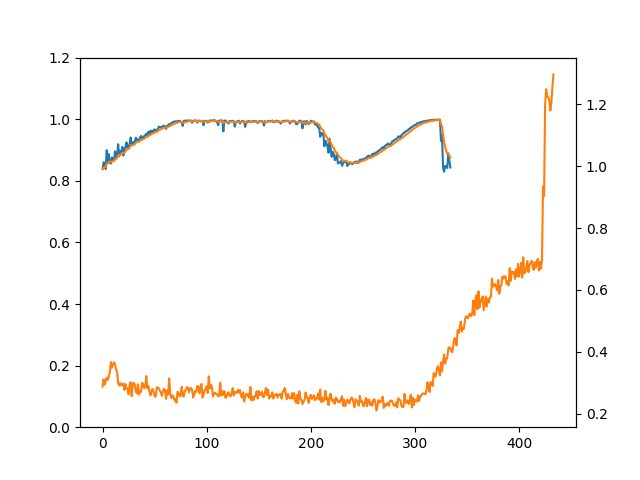

In [4]:
%matplotlib widget
plt.plot(mac)
plt.plot(filter(mac, 0.8))
plt.ylim((0, 1.2))
ax: plt.Axes = plt.twinx(plt.gca())
ax.plot(rms[:, 0], c="tab:orange")

In [5]:
x = {"1": [1200, 140, 1050, 990, 2300, 1480, 1930],
     "2": [160, 210, 450, 200, 530, 340, 40],
     "3": [250, 1340, 240]}